Nivel de atención simulado: 1.1049


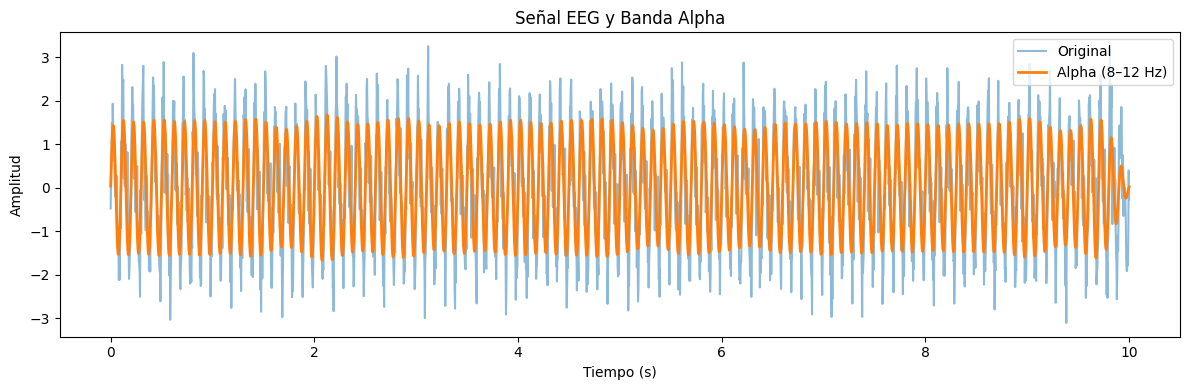

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import pygame
import time

# Cargar señales EEG desde CSV
def cargar_csv(ruta):
    """
    Carga un archivo CSV con señales EEG. Retorna el tiempo y un canal seleccionado.
    """
    df = pd.read_csv(ruta)
    tiempo = df.iloc[:, 0].values  # Primera columna: tiempo
    canal = df.iloc[:, 1].values   # Segunda columna: señal EEG
    return tiempo, canal

# Filtro pasa banda para banda Alpha (8–12 Hz)
def filtrar_alpha(senal, fs):
    """
    Aplica un filtro pasa banda entre 8 y 12 Hz (banda Alpha).
    senal: señal de entrada
    fs: frecuencia de muestreo
    """
    b, a = butter(N=4, Wn=[8, 12], btype='bandpass', fs=fs)
    return filtfilt(b, a, senal)

# Calcular nivel de atención (potencia promedio)
def calcular_atencion(senal_filtrada):
    """
    Devuelve la potencia media de la señal filtrada (simulando nivel de atención).
    """
    potencia = np.mean(senal_filtrada**2)
    return potencia

# Visualizar señal EEG y filtro
def graficar_senales(tiempo, original, filtrada):
    """
    Muestra las señales original y filtrada usando matplotlib.
    """
    plt.figure(figsize=(12, 4))
    plt.plot(tiempo, original, label='Original', alpha=0.5)
    plt.plot(tiempo, filtrada, label='Alpha (8–12 Hz)', linewidth=2)
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.legend()
    plt.title('Señal EEG y Banda Alpha')
    plt.tight_layout()
    plt.show()

def interfaz_dinamica(ruta_csv, fs, ventana_t, umbral):
    tiempo, canal = cargar_csv(ruta_csv)
    total_muestras = len(canal)
    muestras_por_ventana = int(fs * ventana_t)

    pygame.init()
    ancho, alto = 1200, 700
    pantalla = pygame.display.set_mode((ancho, alto))
    pygame.display.set_caption("🧠 BCI Dinámico - Dracula Soft")
    reloj = pygame.time.Clock()

    fuente = pygame.font.SysFont("Consolas", 36, bold=True)
    fuente_titulo = pygame.font.SysFont("Consolas", 48, bold=True)

    # Colores Dracula Soft
    fondo_base = (40, 42, 54)
    fondo_activo = (68, 71, 90)
    color_onda = (139, 233, 253)
    color_barra = (189, 147, 249)
    color_texto = (248, 248, 242)
    color_alerta = (255, 85, 85)

    idx = 0
    ejecutando = True

    while ejecutando:
        for evento in pygame.event.get():
            if evento.type == pygame.QUIT:
                ejecutando = False

        if idx + muestras_por_ventana <= total_muestras:
            ventana = canal[idx:idx+muestras_por_ventana]
            filtrada = filtrar_alpha(ventana, fs)
            potencia = calcular_atencion(filtrada)

            # Cambiar fondo según nivel de atención
            if potencia > umbral:
                color_fondo = fondo_activo
                estado = "ALERTA"
                color_estado = color_alerta
            else:
                color_fondo = fondo_base
                estado = "RELAJADO"
                color_estado = color_barra

            pantalla.fill(color_fondo)

            # Dibujar la onda EEG filtrada
            margen_izq, margen_sup = 100, 150
            ancho_graf = ancho - 2 * margen_izq
            alto_graf = 250
            escala_x = ancho_graf / muestras_por_ventana
            escala_y = alto_graf / (2 * np.max(np.abs(filtrada))) if np.max(np.abs(filtrada)) > 0 else 1
            puntos = [
                (int(margen_izq + i * escala_x), int(margen_sup + alto_graf / 2 - punto * escala_y))
                for i, punto in enumerate(filtrada)
            ]
            if len(puntos) > 1:
                pygame.draw.lines(pantalla, color_onda, False, puntos, 3)

            # Barra de atención (dinámica)
            max_barra = ancho - 200
            longitud_barra = min(int(potencia * 200), max_barra)
            pygame.draw.rect(pantalla, color_barra, (100, alto - 150, longitud_barra, 40), border_radius=10)
            texto_barra = fuente.render(f"Nivel de Atención", True, color_texto)
            pantalla.blit(texto_barra, (100, alto - 200))

            # Mostrar estado y potencia
            texto_estado = fuente.render(f"Estado: {estado}", True, color_estado)
            texto_potencia = fuente.render(f"Potencia: {potencia:.2f}", True, color_texto)
            pantalla.blit(texto_estado, (100, 50))
            pantalla.blit(texto_potencia, (100, 100))

            # Título central
            texto_titulo = fuente_titulo.render("Simulación BCI", True, color_texto)
            pantalla.blit(texto_titulo, (ancho//2 - 300, 10))

            idx += muestras_por_ventana
        else:
            pantalla.fill(fondo_base)
            texto_fin = fuente.render("Fin de la señal", True, color_texto)
            pantalla.blit(texto_fin, (ancho//2 - 100, alto//2))

        pygame.display.flip()
        reloj.tick(1 / ventana_t)

    pygame.quit()

ruta_csv = "../datos/eeg_simulada.csv"  # Asegura que exista este archivo
fs = 250  # Frecuencia de muestreo en Hz (simulada)
    
tiempo, canal = cargar_csv(ruta_csv)
filtrada = filtrar_alpha(canal, fs)
atencion = calcular_atencion(filtrada)

print(f"Nivel de atención simulado: {atencion:.4f}")
graficar_senales(tiempo, canal, filtrada)

ventana_t = 0.2  # Más fluido (0.2s)
umbral = 0.2     # Ajustable según señal

interfaz_dinamica(ruta_csv, fs, ventana_t, umbral)


